In [1]:
import sys, os

sys.path.insert(0, '../../../node2vec')
sys.path.insert(0, '../../../residual2vec_')


In [2]:
os.environ['DISABLE_WANDB'] = 'true'

#disable epoch level tqdm
os.environ['DISABLE_TQDM'] = 'true'
# checking if imports working
import node2vecs
from utils import snakemake_utils
from sklearn.decomposition import PCA
import pandas as pd 
from torch_geometric.data import download_url, extract_zip
import networkx as nx 
import numpy as np 
from scipy import sparse 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle as pkl

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
embs = pkl.load(open("../RESULTS/embs_2.pkl", "rb"))
embs.keys()

dict_keys(['Biased', 'Degree-debiased', 'Degree-Group-debiased', 'Degree-Group-debiased-temp', 'fw_n2v', 'fw_dw', 'cw_n2v', 'cw_dw', 'gat_dw_random', 'gcn_dw_random', 'gat_n2v_random', 'gcn_n2v_random', 'gat_dw_r2v', 'gcn_dw_r2v', 'gat_n2v_r2v', 'gcn_n2v_r2v'])

Using existing file polbooks.zip
Extracting /tmp/ashutiwa/polbooks.zip


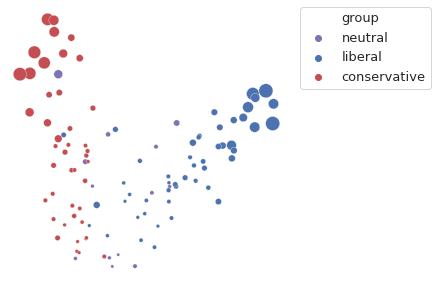

In [4]:
DIM = 16

extract_zip(download_url("http://www-personal.umich.edu/~mejn/netdata/polbooks.zip", "/tmp/ashutiwa/"), "/tmp/ashutiwa/", True)
DATA_FILE = '/tmp/ashutiwa/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G)

def plot_embs(emb, degree, gp_ids, sizes=(10, 200), figsize=(5, 5)):
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data  = pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": [{0: 'liberal', 1:'conservative', 2:'neutral'}[i] for i in gp_ids],
                "model": "Biased",
                "degree": degree
            }
        )

    # %%
    sns.set_style('white')
    sns.set(font_scale=1.0)
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=figsize)
    colors = ["blue", "red", "purple"]
    cmap = sns.color_palette()
    colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}
    g= sns.scatterplot(data = plot_data, x = "x", y = "y", hue = "group", size = "degree", sizes=sizes, palette = colors, ax = ax)
    ax.legend()
    h,l = g.get_legend_handles_labels()
    plt.legend(h[0:4],l[0:4],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    
    ax.axis("off")
    
deg = np.array(A.sum(axis=1)).reshape(-1)

A = (sparse.diags(deg) @ A @ sparse.diags(deg))
deg_ = np.array(A.sum(axis=1)).reshape(-1)

plot_embs(emb=embs['Biased'], degree=deg_, gp_ids=group_ids)

# remove degree debiased
# drop fairwalk
# all these 8 images in one



# only deepwalk here 

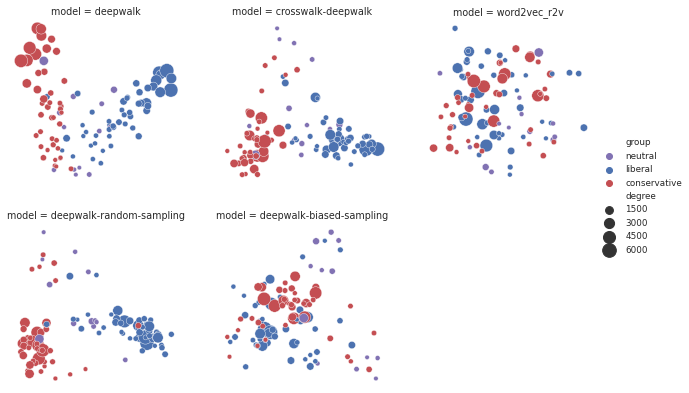

In [17]:
plot_data_all = []

# deg = np.array(A.sum(axis=0)).reshape(-1)
row = 0
ordered = ['Biased', 'cw_dw', 'Degree-Group-debiased', 'gat_dw_random', 'gat_dw_r2v', ] # 'gat_n2v_random', 'gat_n2v_r2v', 
# keys = ['fw_dw', 'cw_dw']
mp = {'Biased': 'deepwalk',
    'gat_n2v_random': 'gat-node2vec-random-sampling', 'gat_n2v_r2v': 'gat-node2vec-biased-sampling', 
    'gat_dw_random': 'deepwalk-random-sampling', 'gat_dw_r2v': 'deepwalk-biased-sampling',
     'gcn_dw_random': 'deepwalk-random-sampling', 'gcn_dw_r2v': 'deepwalk-biased-sampling',
   'fw_dw': 'fairwalk-deepwalk', 'cw_dw': 'crosswalk-deepwalk', 'fw_n2v': "fairwalk-node2vec", 'cw_n2v': "crosswalk-node2vec",  
'Degree-Group-debiased': 'word2vec_r2v'}
# mp = {
#     'gat_dw_random': 'biased', 'gat_dw_r2v': 'unbiased', 'Biased': 'biased', 'cw_dw': 'unbiased'
# }
for idx, k in enumerate(ordered):
    if k not in keys: continue
    emb = embs[k]
    
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data_all += [
        pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": [{0: 'liberal', 1:'conservative', 2:'neutral'}[i] for i in group_ids],
                "model": mp[k],
                "degree": deg_,
    
            }
        )
    ]

plot_data_all = pd.concat(plot_data_all)
#
sns.set_style("white")
sns.set(font_scale=.8)
sns.set_style("ticks")

# fig, ax = plt.subplots(figsize=(7,5))

g = sns.FacetGrid(
    data=plot_data_all,
#     row="row",
    col='model',
    sharex=False,
    sharey=False,
    col_wrap=3
    
)


cmap = sns.color_palette()
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}
g.map(sns.scatterplot, "x", "y", "group", "degree", sizes=(20, 200), palette = colors)
# g.fig.suptitle("WORD2VEC")
# g.axes[0, 0].legend()


for (i,j,k), data in g.facet_data():

    ax = g.facet_axis(i, j)
    ax.set_axis_off()
    h,l = ax.get_legend_handles_labels()
#     ax.legend(h[0:4],l[0:4],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=5)
#     print(h, l)


g.add_legend()
